In [2]:
import matplotlib as mpl

# Global font settings for a publication-style look
mpl.rcParams['font.family'] = 'serif'              # Use serif font (e.g., Times)
mpl.rcParams['font.serif'] = ['Times New Roman']   # Or 'Computer Modern', 'Georgia', etc.
mpl.rcParams['font.size'] = 12                     # Default font size for text
mpl.rcParams['axes.titlesize'] = 14                # Bigger title font
mpl.rcParams['axes.labelsize'] = 12                # Axis label font
mpl.rcParams['legend.fontsize'] = 11               # Legend font
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['lines.linewidth'] = 2.5              # Thicker lines
mpl.rcParams['axes.linewidth'] = 1.0   

<>:172: SyntaxWarning: invalid escape sequence '\s'
<>:173: SyntaxWarning: invalid escape sequence '\s'
<>:174: SyntaxWarning: invalid escape sequence '\s'
<>:172: SyntaxWarning: invalid escape sequence '\s'
<>:173: SyntaxWarning: invalid escape sequence '\s'
<>:174: SyntaxWarning: invalid escape sequence '\s'
/var/folders/fb/bj26nwg53_9f8y2m3r24s2rh0000gn/T/ipykernel_1798/1242780656.py:172: SyntaxWarning: invalid escape sequence '\s'
  plot_quantity(results, SN_list, 'S', 'Dimensionless Substrate $S^*$', 'Substrate Distribution Over Distance(t = 0.1, $\sigma^2 = 0.1$)', "S_plot")
/var/folders/fb/bj26nwg53_9f8y2m3r24s2rh0000gn/T/ipykernel_1798/1242780656.py:173: SyntaxWarning: invalid escape sequence '\s'
  plot_quantity(results, SN_list, 'P', 'Dimensionless Product $P^*$', 'Product Distribution Over Distance(t = 0.1, $\sigma^2 = 0.1$)', "P_plot")
/var/folders/fb/bj26nwg53_9f8y2m3r24s2rh0000gn/T/ipykernel_1798/1242780656.py:174: SyntaxWarning: invalid escape sequence '\s'
  plot_quanti

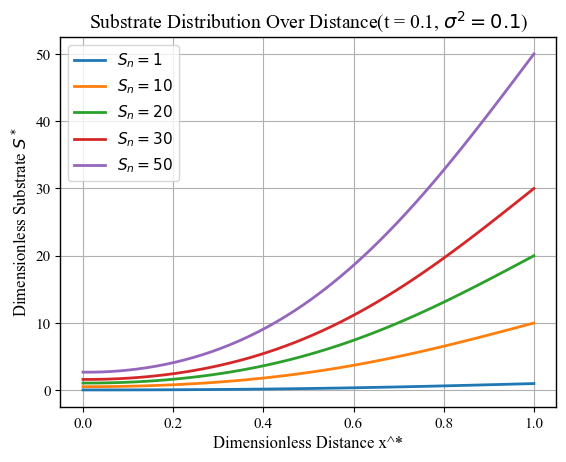

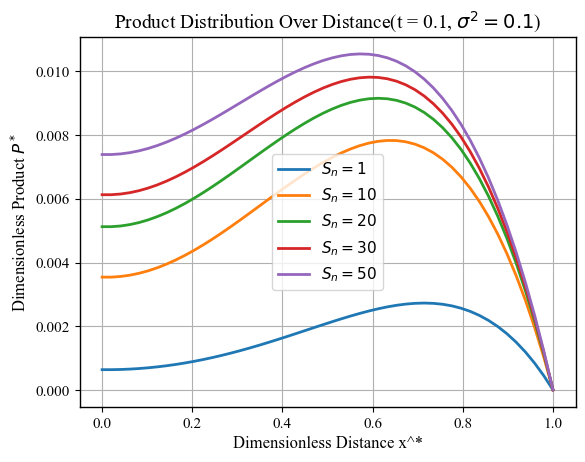

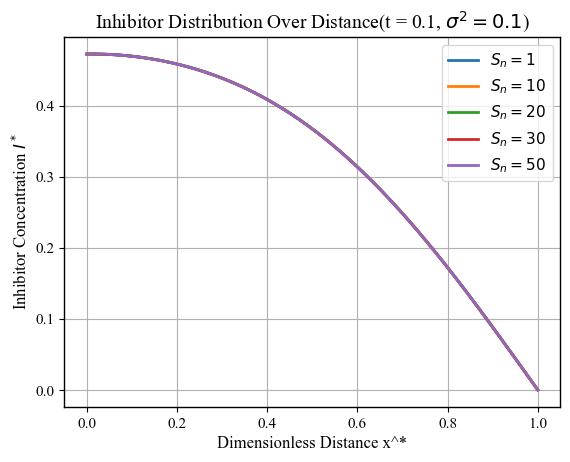

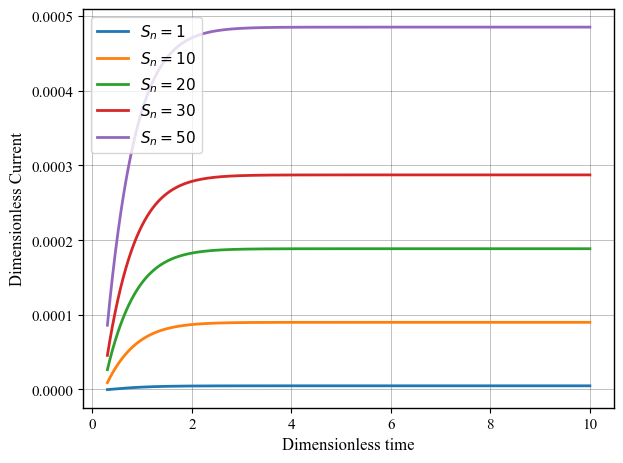

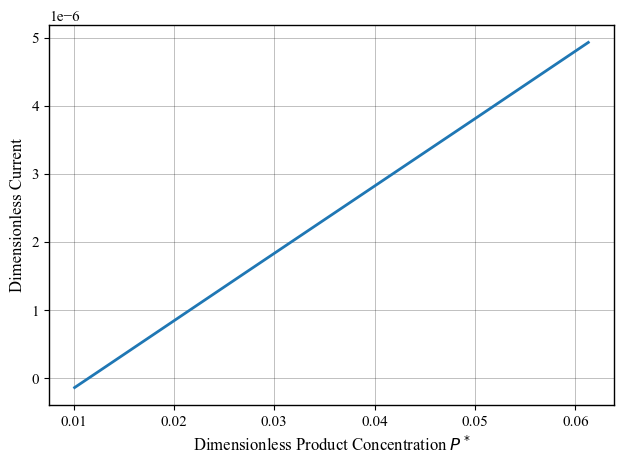

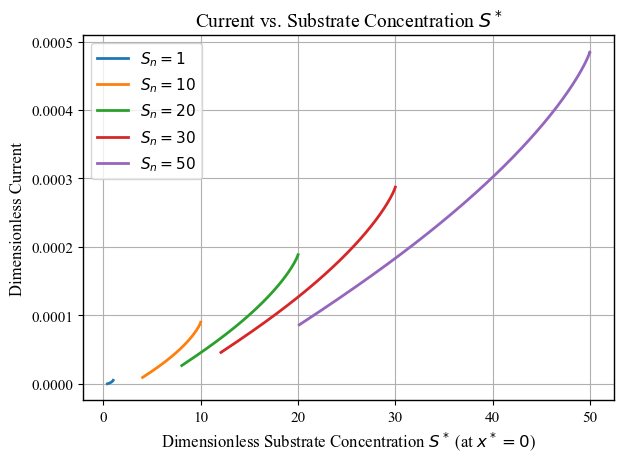

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

"""
This script uses the explicit finite difference method (FDM) to solve a system of coupled partial differential equations (PDEs) modeling the concentration profiles of substrate (S), product (P), and inhibitor (I) in a 1D biosensor system with uncompetitive inhibition.

Key Parameters:
- sigma: dimensionless Damkohler number for substrate
- sigma_prime: dimensionless Damkohler number for product
- K_prime: dimensionless inhibition constant
- beta: CFL condition value for numerical stability (dt / dx^2)

We explore the behavior of the system for different boundary values of substrate concentration (S0).
"""

# -------------------- PARAMETERS --------------------
# Model parameters
sigma = 0.1      # Damkohler number for substrate, determines reaction rate compared to diffusion rate
sigma_prime = 0.5  # Damkohler number for product, affects product formation rate
K_prime = 1.0      # Dimensionless inhibition constant, influences the strength of inhibition
X = 1              # Dimensionless spatial domain (0 <= x <= 1)
T = 10             # Dimensionless time domain (0 <= t <= 10)
xnum = 50          # Number of spatial nodes for discretization
tnum = 150000      # Number of time steps for discretization

# Spatial and time discretization
x = np.linspace(0, X, xnum)  # Discretizing the spatial domain into 'xnum' points
dx = x[1] - x[0]  # Spatial step size, calculated from the discretized spatial grid
t = np.linspace(0, T, tnum + 1)  # Discretizing the time domain into 'tnum' steps
dt = t[1] - t[0]  # Time step size, calculated from the discretized time grid

# Physical constants
ne = 2            # Number of electrons transferred in the reaction
F = 96.486        # Faraday constant [C/mmol]
Ds = 1 / 1e9      # Substrate diffusion coefficient [m^2/s]
Dp = 1 / 1e9      # Product diffusion coefficient [m^2/s]
Di = 1 / 1e9      # Inhibitor diffusion coefficient [m^2/s]
d = 1e-4          # Enzyme layer thickness [m]

# Diffusion ratios
R = Dp / Ds       # Ratio of product-to-substrate diffusivity (expected to be 1.0 here)
Ri = Di / Ds      # Ratio of inhibitor-to-substrate diffusivity (expected to be 1.0 here)

# CFL condition calculation for stability
beta = dt / dx**2  # CFL condition for numerical stability, required to be less than 0.5
if beta >= 0.5:
    print('Warning: beta is larger than 0.5:', beta)

# Initial conditions
Si = 0     # Initial substrate concentration
Ii = 0.5   # Initial inhibitor concentration
SN_list = [1, 10, 20, 30, 50]  # List of boundary substrate concentrations for testing


# -------------------- FUNCTIONS --------------------
def explicit_fdm_with_inhibition(X, xnum, tnum, Si, Ii, beta, sigma, sigma_prime, K_prime, dt, dx, SN_list):
    results = {}

    for SN in SN_list:
        S = np.zeros((tnum + 1, xnum))
        P = np.zeros((tnum + 1, xnum))
        I = np.zeros((tnum + 1, xnum))

        # Initial conditions
        S[0, :] = Si
        I[0, :] = Ii
        S[:, -1] = SN  # Dirichlet BC at x = L

        for t_step in range(1, tnum + 1):
            # Step 1: update inhibitor first
            for j in range(1, xnum - 1):
                inhibitor_term = 1 + I[t_step - 1, j] / K_prime
                reaction = S[t_step - 1, j] / ((S[t_step - 1, j] + 1) * inhibitor_term)
                I[t_step, j] = beta * Ri * (I[t_step - 1, j + 1] + I[t_step - 1, j - 1]) + \
                               (1 - 2 * beta * Ri) * I[t_step - 1, j] - (sigma ** 2) * reaction * dt
            I[t_step, 0] = I[t_step, 1]  # Neumann BC

            # Step 2: update substrate and product using new I[t_step]
            for j in range(1, xnum - 1):
                inhibitor_term = 1 + I[t_step, j] / K_prime
                reaction = S[t_step - 1, j] / ((S[t_step - 1, j] + 1) * inhibitor_term)

                S[t_step, j] = beta * (S[t_step - 1, j + 1] + S[t_step - 1, j - 1]) + \
                               (1 - 2 * beta) * S[t_step - 1, j] - (sigma ** 2) * reaction * dt

                P[t_step, j] = beta * R * (P[t_step - 1, j + 1] + P[t_step - 1, j - 1]) + \
                               (1 - 2 * beta * R) * P[t_step - 1, j] + (sigma_prime ** 2) * reaction * dt

            S[t_step, 0] = S[t_step, 1]  # Neumann BC
            P[t_step, 0] = P[t_step, 1]  # Neumann BC

        results[SN] = {'S': S, 'P': P, 'I': I}

    return results

# Plotting Functions of S, I and P Dimensionlessly
def plot_quantity(results, SN_list, quantity_key, ylabel, title, file_name):
    """
    Plots concentration profiles for S, P, or I for different substrate boundary values (SN).
    Saves each plot with a unique file name.
    """
    fig, ax = plt.subplots()
    for SN in SN_list:
        ax.plot(x, results[SN][quantity_key][int(0.1 / dt), :], label=f'$S_{{n}}={SN}$', linewidth=2)
    ax.set_xlabel('Dimensionless Distance x^*')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    
    # Save the plot with a unique name
    plt.savefig(f"{file_name}.png", dpi=300)
    plt.show()


def current_time(results, T, dt, dx, ne, F, Ds, d, tnum):
    t = np.linspace(0, T, tnum + 1)
    fig, ax = plt.subplots()
    for S0 in SN_list:
        P = results[S0]['P']
        current = (ne * F * Ds * S0 / d) * ((P[:, 1] - P[:, 2]) / dx)
        ax.plot(t[int(0.3 / dt):], current[int(0.3 / dt):], label=f'$S_{{n}}={S0}$', linewidth=2)
    ax.set_xlabel('Dimensionless time')
    ax.set_ylabel('Dimensionless Current')
    ax.grid(which='major', linestyle='-', linewidth=0.7, color='black', alpha=0.25)
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='green', alpha=0.2)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"current_time.png", dpi=300)
    plt.show()

def current_product(results, dx, F, ne, Ds, d, tnum, dt):
    S0 = 1
    P = results[S0]['P']
    current_prime = (ne * F * Ds * S0 / d) * ((P[:, 1] - P[:, 2]) / dx)
    fig, ax = plt.subplots()
    ax.plot(P[int(0.3 / dt):, 0], current_prime[int(0.3 / dt):], linewidth=2)
    ax.set_xlabel('Dimensionless Product Concentration $P^*$')
    ax.set_ylabel('Dimensionless Current')
    ax.grid(which='major', linestyle='-', linewidth=0.7, color='black', alpha=0.25)
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='green', alpha=0.2)
    plt.tight_layout()
    plt.savefig(f"current-product.png", dpi=300)
    plt.show()

def current_vs_substrate(results, dx, F, ne, Ds, d, tnum, dt):
    """
    Plots dimensionless current vs. dimensionless substrate concentration S* for a given boundary S0.
    """
    fig, ax = plt.subplots()
    for S0 in SN_list:
        S = results[S0]['S']
        P = results[S0]['P']
        current = (ne * F * Ds * S0 / d) * ((P[:, 1] - P[:, 2]) / dx)
        substrate_surface = S[:, 0]  # substrate at x = 0 (electrode side)
        ax.plot(substrate_surface[int(0.3/dt):], current[int(0.3/dt):], label=f'$S_{{n}}={S0}$', linewidth=2)

    ax.set_xlabel('Dimensionless Substrate Concentration $S^*$ (at $x^*=0$)')
    ax.set_ylabel('Dimensionless Current')
    ax.set_title('Current vs. Substrate Concentration $S^*$')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"current-vs-substrate.png", dpi=600)
    plt.show()


# -------------------- SIMULATIONS --------------------
results = explicit_fdm_with_inhibition(X, xnum, tnum, Si, Ii, beta, sigma, sigma_prime, K_prime, dt, dx, SN_list)
dt_eff = T / (tnum + 1)
plot_quantity(results, SN_list, 'S', 'Dimensionless Substrate $S^*$', 'Substrate Distribution Over Distance(t = 0.1, $\sigma^2 = 0.1$)', "S_plot")
plot_quantity(results, SN_list, 'P', 'Dimensionless Product $P^*$', 'Product Distribution Over Distance(t = 0.1, $\sigma^2 = 0.1$)', "P_plot")
plot_quantity(results, SN_list, 'I', 'Inhibitor Concentration $I^*$', 'Inhibitor Distribution Over Distance(t = 0.1, $\sigma^2 = 0.1$)', "I_plot")
current_time(results, T, dt_eff, dx, ne, F, Ds, d, tnum)
current_product(results, dx, F, ne, Ds, d, tnum, dt_eff)
current_vs_substrate(results, dx, F, ne, Ds, d, tnum, dt_eff)


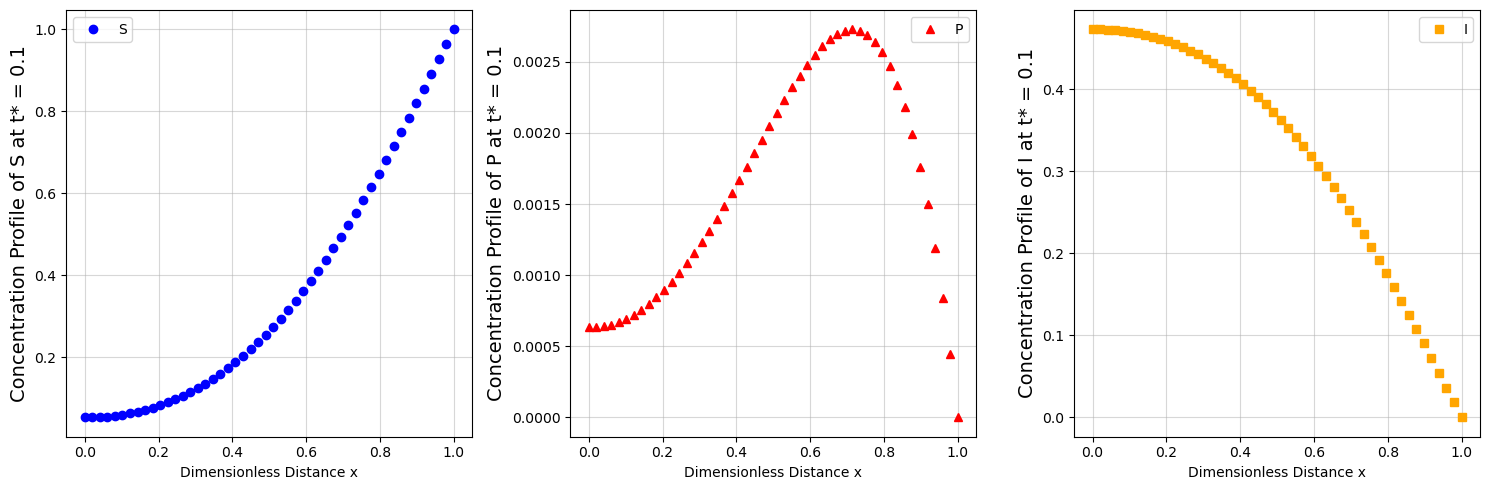

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# -------------------- PARAMETERS --------------------
sigma = 0.1          # Dimensionless Damkohler number for substrate
sigma_prime = 0.5    # Dimensionless Damkohler number for product
K_prime = 1.0        # Dimensionless inhibition constant
X = 1              # Dimensionless spatial domain [0, 1]
T = 2              # Dimensionless time domain [0, T]
xnum = 50            # Number of spatial steps
tnum = 10000        # Number of time steps

x = np.linspace(0, X, xnum)
dx = x[1] - x[0]     # Spatial step size
t = np.linspace(0, T, tnum + 1)
dt = t[1] - t[0]  # Time step size 
beta = dt / dx**2  # Recalculate beta

if beta >= 0.5:
    print(f'Warning: beta is too large: {beta}. Consider reducing dt or increasing xnum.')


# Physical constants
ne = 2               # Number of electrons
F = 96.486           # Faraday constant [C/mmol]
Ds = 1 / 1e9         # Substrate diffusion coefficient [m^2/s]
Dp = 1 / 1e9         # Product diffusion coefficient [m^2/s]
Di = 1 / 1e9         # Inhibitor diffusion coefficient [m^2/s]
d = 1e-4             # Enzyme layer thickness [m]

R = Dp / Ds          # Diffusion ratio for product
Ri = Di / Ds         # Diffusion ratio for inhibitor


# Initial and boundary conditions
Si = 0               # Initial substrate concentration
Ii = 0.5             # Initial inhibitor concentration
SN = 1             # Substrate boundary value at x = 1

# -------------------- FUNCTIONS --------------------
# Function to calculate the concentration profiles of S, P, and I for single SN
def explicit_fdm_with_inhibition(xnum, tnum, SN, dt, dx, sigma, sigma_prime, K_prime, R, Ri, beta):
    x = np.linspace(0, 1, xnum)
    S = np.zeros((tnum + 1, xnum))
    P = np.zeros((tnum + 1, xnum))
    I = np.zeros((tnum + 1, xnum))

    S[0, :] = Si
    I[0, :] = Ii
    S[:, -1] = SN  # Dirichlet BC at x = X

    for t_step in range(1, tnum + 1):
        for j in range(1, xnum - 1):
            inhibitor_term = 1 + I[t_step - 1, j] / K_prime
            reaction = (S[t_step - 1, j] / ((S[t_step - 1, j] + 1) * inhibitor_term))

            I[t_step, j] = beta * Ri * (I[t_step - 1, j + 1] + I[t_step - 1, j - 1]) + \
                           (1 - 2 * beta * Ri) * I[t_step - 1, j] - (sigma**2) * reaction * dt
        
        I[t_step, 0] = I[t_step, 1]

        for j in range(1, xnum - 1):
            inhibitor_term = 1 + I[t_step, j] / K_prime
            if inhibitor_term == 0 or np.isnan(inhibitor_term) or np.isinf(inhibitor_term):
                inhibitor_term = 1e-10  # Avoid division by zero

            reaction = (S[t_step - 1, j] / ((S[t_step - 1, j] + 1) * inhibitor_term))
            
            if np.isnan(reaction) or np.isinf(reaction):
                reaction = 0  # Prevent propagation of errors

            S[t_step, j] = beta * (S[t_step - 1, j + 1] + S[t_step - 1, j - 1]) + \
                           (1 - 2 * beta) * S[t_step - 1, j] - (sigma**2) * reaction * dt
            P[t_step, j] = beta * R * (P[t_step - 1, j + 1] + P[t_step - 1, j - 1]) + \
                           (1 - 2 * beta * R) * P[t_step - 1, j] + (sigma_prime**2) * reaction * dt

        S[t_step, 0] = S[t_step, 1]
        P[t_step, 0] = P[t_step, 1]
    
    return S, P, I, x

# -------------------- SIMULATION --------------------
# Run simulation for single SN = 1
S, P, I, x = explicit_fdm_with_inhibition(xnum, tnum, SN, dt, dx, sigma, sigma_prime, K_prime, R, Ri, beta)

# Plot results at t = 0.1
# Plot results at t = 0.1
t_index = int(0.1 / dt)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), tight_layout=True)
ax[0].plot(x, S[t_index], marker='o', markerfacecolor='blue', markeredgecolor='blue', markersize=6, linestyle='', label='S')
ax[0].set_xlabel('Dimensionless Distance x')
ax[0].set_ylabel('Concentration Profile of S at t* = 0.1', fontsize=14)
ax[0].grid(alpha=0.5)
ax[0].legend(loc='best')

ax[1].plot(x, P[t_index], marker='^', markerfacecolor='red', markeredgecolor='red', markersize=6, linestyle='', label='P')
ax[1].set_xlabel('Dimensionless Distance x')
ax[1].set_ylabel('Concentration Profile of P at t* = 0.1', fontsize=14)
ax[1].grid(alpha=0.5)
ax[1].legend(loc='best')

ax[2].plot(x, I[t_index], marker='s', markerfacecolor='orange', markeredgecolor='orange', markersize=6, linestyle='', label='I')
ax[2].set_xlabel('Dimensionless Distance x')
ax[2].set_ylabel('Concentration Profile of I at t* = 0.1', fontsize=14)
ax[2].grid(alpha=0.5)
ax[2].legend(loc='best')
plt.savefig(f"single_sn.png", dpi=300)
plt.show()


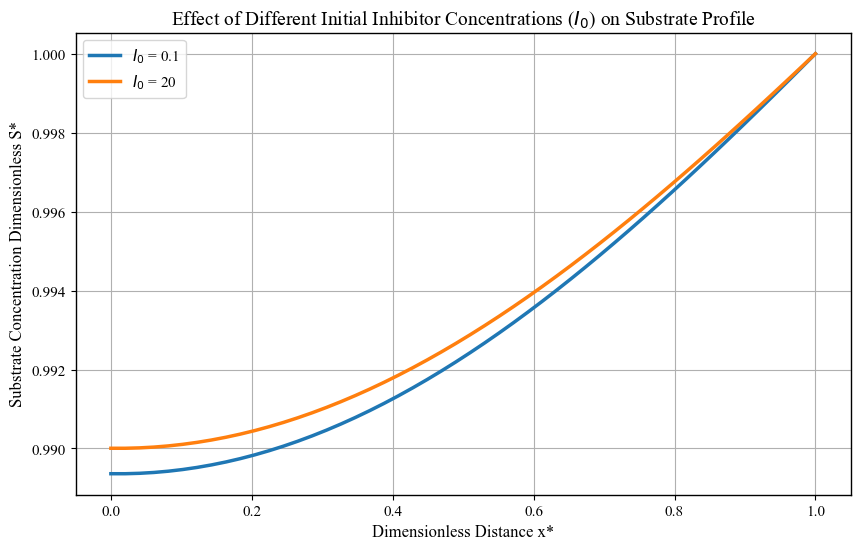

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------- PARAMETERS --------------------
sigma = 0.1          # Dimensionless Damkohler number for substrate
sigma_prime = 0.5    # Dimensionless Damkohler number for product
K_prime = 1.0        # Dimensionless inhibition constant
X = 1              # Dimensionless spatial domain [0, 1]
T = 2              # Dimensionless time domain [0, T]
xnum = 50            # Number of spatial steps
tnum = 11000        # Number of time steps

x = np.linspace(0, X, xnum)
dx = x[1] - x[0]     # Spatial step size
t = np.linspace(0, T, tnum + 1)
dt = t[1] - t[0]     # Time step size


# Physical constants
ne = 2               # Number of electrons
F = 96.486           # Faraday constant [C/mmol]
Ds = 1 / 1e9         # Substrate diffusion coefficient [m^2/s]
Dp = 1 / 1e9         # Product diffusion coefficient [m^2/s]
Di = 1 / 1e9         # Inhibitor diffusion coefficient [m^2/s]
d = 1e-4             # Enzyme layer thickness [m]

R = Dp / Ds          # Diffusion ratio for product
Ri = Di / Ds         # Diffusion ratio for inhibitor

beta = dt / dx**2    # CFL condition

if beta >= 0.5:
    print('Warning: beta is larger than 0.5:', beta)

# Initial and boundary conditions
Si = 0               # Initial substrate concentration
Ii = 0.5             # Initial inhibitor concentration
SN = 1             # Substrate boundary value at x = 1

# -------------------- EXPLICIT FDM WITH INHIBITION --------------------
def explicit_fdm_with_inhibition(xnum, tnum, SN, dt, dx, sigma, sigma_prime, K_prime, R, Ri, beta):
    x = np.linspace(0, 1, xnum)
    S = np.zeros((tnum + 1, xnum))
    P = np.zeros((tnum + 1, xnum))
    I = np.zeros((tnum + 1, xnum))

    S[0, :] = Si
    I[0, :] = Ii
    S[:, -1] = SN  # Dirichlet BC at x = X

    for t_step in range(1, tnum + 1):
        for j in range(1, xnum - 1):
            inhibitor_term = 1 + I[t_step - 1, j] / K_prime
            reaction = (S[t_step - 1, j] / ((S[t_step - 1, j] + 1) * inhibitor_term))
            I[t_step, j] = beta * Ri * (I[t_step - 1, j + 1] + I[t_step - 1, j - 1]) + \
                           (1 - 2 * beta * Ri) * I[t_step - 1, j] - (sigma**2) * reaction * dt
        
        I[t_step, 0] = I[t_step, 1]

        for j in range(1, xnum - 1):
            inhibitor_term = 1 + I[t_step, j] / K_prime
            reaction = (S[t_step - 1, j] / ((S[t_step - 1, j] + 1) * inhibitor_term))
            S[t_step, j] = beta * (S[t_step - 1, j + 1] + S[t_step - 1, j - 1]) + \
                           (1 - 2 * beta) * S[t_step - 1, j] - (sigma**2) * reaction * dt
            P[t_step, j] = beta * R * (P[t_step - 1, j + 1] + P[t_step - 1, j - 1]) + \
                           (1 - 2 * beta * R) * P[t_step - 1, j] + (sigma_prime**2) * reaction * dt

        S[t_step, 0] = S[t_step, 1]
        P[t_step, 0] = P[t_step, 1]
    
    return S, P, I, x

def plot_comparison(I0_values, x, tnum, S_profiles):
    plt.figure(figsize=(10, 6))
    for i, I0 in enumerate(I0_values):
        plt.plot(x, S_profiles[i][tnum, :], label=f'$I_0$ = {I0}')
    plt.xlabel('Dimensionless Distance x*')
    plt.ylabel('Substrate Concentration Dimensionless S*')
    plt.title('Effect of Different Initial Inhibitor Concentrations ($I_0$) on Substrate Profile')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"comparsion for $I_0$.png", dpi=300)
    plt.show()


# -------------------- PLOTTING --------------------
I0_values = [0.1, 20]  # Testing different initial inhibitor concentrations
S_profiles = []

for I0 in I0_values:
    Ii = I0  # Set the initial inhibitor concentration
    S, P, I, x = explicit_fdm_with_inhibition(xnum, tnum, SN, dt, dx, sigma, sigma_prime, K_prime, R, Ri, beta)
    S_profiles.append(S)

plot_comparison(I0_values, x, tnum, S_profiles)


<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\s'
/var/folders/fb/bj26nwg53_9f8y2m3r24s2rh0000gn/T/ipykernel_1798/1830671814.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, S_profiles_sigma[i][tnum, :], label=f'$\sigma^2$ = {sigma}')
/var/folders/fb/bj26nwg53_9f8y2m3r24s2rh0000gn/T/ipykernel_1798/1830671814.py:29: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Substrate Concentration ($S^*$) for Different $\sigma^2$ Values')  # Title of the plot
/var/folders/fb/bj26nwg53_9f8y2m3r24s2rh0000gn/T/ipykernel_1798/1830671814.py:42: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, P_profiles_sigma[i][tnum,

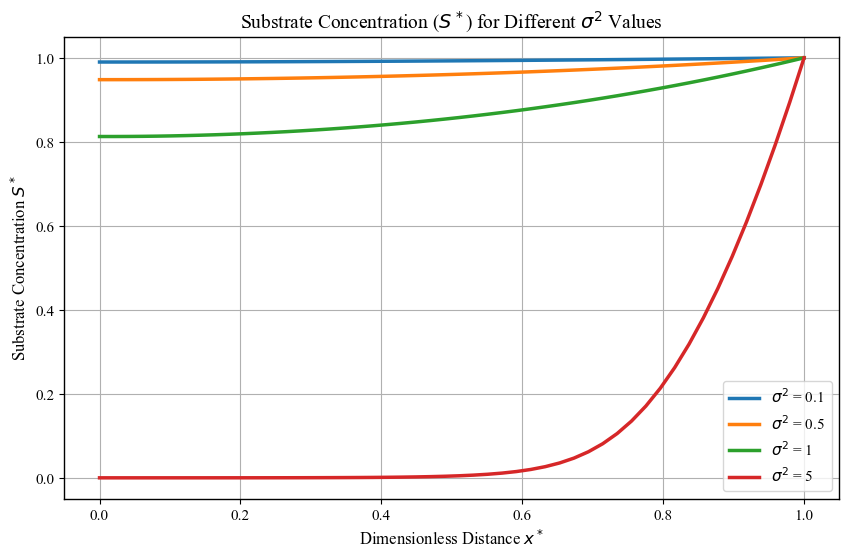

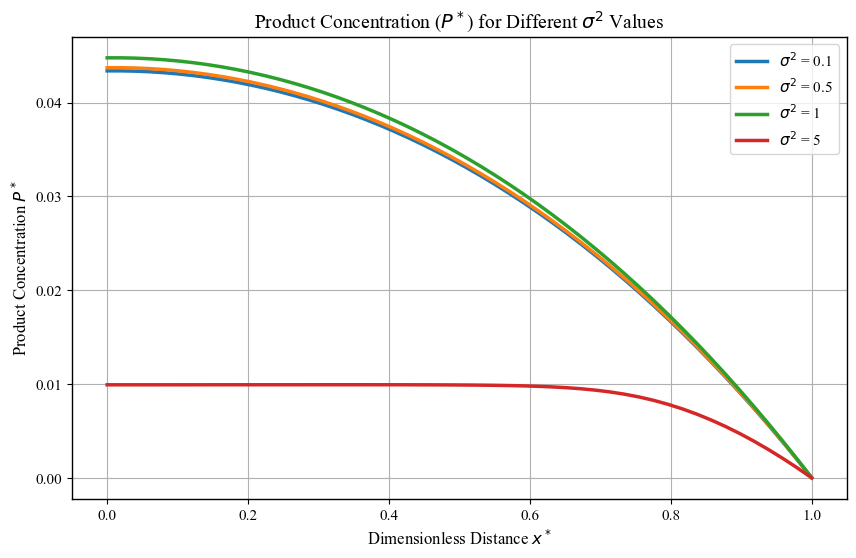

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------- PARAMETERS --------------------
sigma_values = [0.1, 0.5, 1, 5]

# Initialize lists to store profiles for each sigma
S_profiles_sigma = []
P_profiles_sigma = []
I_profiles_sigma = []

# Loop over sigma values and compute profiles
for sigma in sigma_values:
    S, P, I, x = explicit_fdm_with_inhibition(xnum, tnum, SN, dt, dx, sigma, sigma_prime, K_prime, R, Ri, beta)
    S_profiles_sigma.append(S)
    P_profiles_sigma.append(P)
    I_profiles_sigma.append(I)

# -------------------- PLOTTING: SUBSTRATE PROFILES --------------------
# Plot the substrate profiles for different sigma values on a single plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Loop through the profiles for each sigma value and plot them
for i, sigma in enumerate(sigma_values):
    plt.plot(x, S_profiles_sigma[i][tnum, :], label=f'$\sigma^2$ = {sigma}')
    
plt.xlabel('Dimensionless Distance $x^*$')  # Label for the x-axis
plt.ylabel('Substrate Concentration $S^*$')  # Label for the y-axis
plt.title('Substrate Concentration ($S^*$) for Different $\sigma^2$ Values')  # Title of the plot
plt.legend()  # Display the legend showing sigma values
plt.grid(True)  # Display grid lines for better readability
plt.savefig("S_profiles_sigma.png", dpi=300)  # Save the plot as a PNG file with high resolution
plt.show()  # Display the plot on the screen

# -------------------- PLOTTING: PRODUCT PROFILES --------------------

# Plot the product profiles for different sigma values on a single plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Loop through the profiles for each sigma value and plot them
for i, sigma in enumerate(sigma_values):
    plt.plot(x, P_profiles_sigma[i][tnum, :], label=f'$\sigma^2$ = {sigma}')
    
plt.xlabel('Dimensionless Distance $x^*$')  # Label for the x-axis
plt.ylabel('Product Concentration $P^*$')  # Label for the y-axis
plt.title('Product Concentration ($P^*$) for Different $\sigma^2$ Values')  # Title of the plot
plt.legend()  # Display the legend showing sigma values
plt.grid(True)  # Display grid lines for better readability
plt.savefig("P_profiles_sigma.png", dpi=300)  # Save the plot as a PNG file with high resolution
plt.show()  # Display the plot on the screen

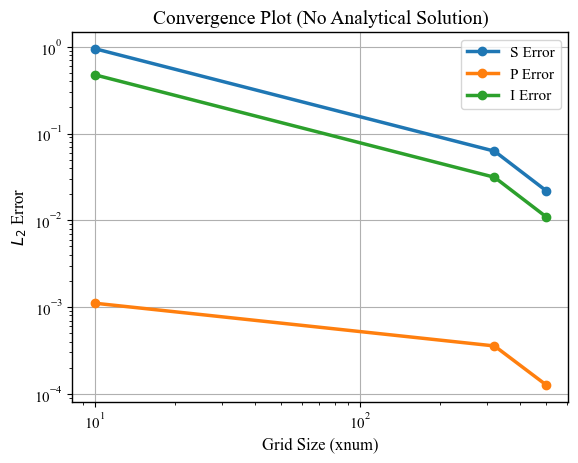

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# -------------------- PARAMETERS --------------------
sigma = 0.1          # Dimensionless Damkohler number for substrate
sigma_prime = 0.5    # Dimensionless Damkohler number for product
K_prime = 1.0        # Dimensionless inhibition constant
X = 1              # Dimensionless spatial domain [0, 1]
T = 2              # Dimensionless time domain [0, T]
xnum = 50            # Number of spatial steps
tnum = 10000 

x = np.linspace(0, X, xnum)
dx = x[1] - x[0]     # Spatial step size
t = np.linspace(0, T, tnum + 1)
dt = t[1] - t[0]  # Time step size 
beta = dt / dx**2  # Recalculate beta

if beta >= 0.5:
    print(f'Warning: beta is too large: {beta}. Consider reducing dt or increasing xnum.')


# Physical constants
ne = 2               # Number of electrons
F = 96.486           # Faraday constant [C/mmol]
Ds = 1 / 1e9         # Substrate diffusion coefficient [m^2/s]
Dp = 1 / 1e9         # Product diffusion coefficient [m^2/s]
Di = 1 / 1e9         # Inhibitor diffusion coefficient [m^2/s]
d = 1e-4             # Enzyme layer thickness [m]

R = Dp / Ds          # Diffusion ratio for product
Ri = Di / Ds         # Diffusion ratio for inhibitor


# Initial and boundary conditions
Si = 0               # Initial substrate concentration
Ii = 0.5             # Initial inhibitor concentration
SN = 1             # Substrate boundary value at x = 1

# -------------------- FUNCTIONS --------------------
# Error calculation function between two grids
def calculate_error(fine, coarse, x_fine, x_coarse):
    # Initialize an array to store interpolated coarse values
    interpolated_coarse = np.zeros_like(fine)

    # Loop through all fine grid points
    fine_len = len(x_fine)
    coarse_len = len(x_coarse)
    
    for i in range(fine_len):
        x_f = x_fine[i]
        
        # Find the closest left and right coarse grid points
        for j in range(coarse_len - 1):
            if x_coarse[j] <= x_f <= x_coarse[j + 1]:
                # Linear interpolation formula
                x_left, x_right = x_coarse[j], x_coarse[j + 1]
                f_left, f_right = coarse[j], coarse[j + 1]
                
                # Calculate the interpolated value
                interpolated_value = f_left + (f_right - f_left) * (x_f - x_left) / (x_right - x_left)
                interpolated_coarse[i] = interpolated_value
                break

    # Calculate the L2 error norm
    error = np.sqrt(np.sum((fine - interpolated_coarse) ** 2) / fine_len)
    
    return error

# Grid refinement study without analytical solution
def explicit_fdm_with_inhibition(xnum, tnum, SN, dt, dx, sigma, sigma_prime, K_prime, R, Ri, beta):
    x = np.linspace(0, 1, xnum)
    S = np.zeros((tnum + 1, xnum))
    P = np.zeros((tnum + 1, xnum))
    I = np.zeros((tnum + 1, xnum))

    S[0, :] = Si
    I[0, :] = Ii
    S[:, -1] = SN  # Dirichlet BC at x = X

    for t_step in range(1, tnum + 1):
        for j in range(1, xnum - 1):
            inhibitor_term = 1 + I[t_step - 1, j] / K_prime
            if inhibitor_term == 0 or np.isnan(inhibitor_term) or np.isinf(inhibitor_term):
                inhibitor_term = 1e-10  # Avoid division by zero

            reaction = (S[t_step - 1, j] / ((S[t_step - 1, j] + 1) * inhibitor_term))
            
            if np.isnan(reaction) or np.isinf(reaction):
                reaction = 0  # Prevent propagation of errors

            I[t_step, j] = beta * Ri * (I[t_step - 1, j + 1] + I[t_step - 1, j - 1]) + \
                           (1 - 2 * beta * Ri) * I[t_step - 1, j] - (sigma**2) * reaction * dt
        
        I[t_step, 0] = I[t_step, 1]

        for j in range(1, xnum - 1):
            inhibitor_term = 1 + I[t_step, j] / K_prime
            if inhibitor_term == 0 or np.isnan(inhibitor_term) or np.isinf(inhibitor_term):
                inhibitor_term = 1e-10  # Avoid division by zero

            reaction = (S[t_step - 1, j] / ((S[t_step - 1, j] + 1) * inhibitor_term))
            
            if np.isnan(reaction) or np.isinf(reaction):
                reaction = 0  # Prevent propagation of errors

            S[t_step, j] = beta * (S[t_step - 1, j + 1] + S[t_step - 1, j - 1]) + \
                           (1 - 2 * beta) * S[t_step - 1, j] - (sigma**2) * reaction * dt
            P[t_step, j] = beta * R * (P[t_step - 1, j + 1] + P[t_step - 1, j - 1]) + \
                           (1 - 2 * beta * R) * P[t_step - 1, j] + (sigma_prime**2) * reaction * dt

        S[t_step, 0] = S[t_step, 1]
        P[t_step, 0] = P[t_step, 1]
    
    return S, P, I, x

# -------------------- SIMULATION --------------------
# Test the code with grid refinement
SN = 1
sigma = 0.1
sigma_prime = 0.5
K_prime = 1.0
R = 1
Ri = 1
tnum = 1000
dt = 0.0001
beta = 0.4  # Chosen to be below stability threshold

xnum_list = [10,320, 500, 600]   # Different grid sizes
errors_S = []
errors_P = []
errors_I = []

for i in range(len(xnum_list)-1):
    xnum_fine = xnum_list[i+1]
    xnum_coarse = xnum_list[i]

    dx_fine = 1 / (xnum_fine - 1)
    dx_coarse = 1 / (xnum_coarse - 1)

    S_fine, P_fine, I_fine, x_fine = explicit_fdm_with_inhibition(xnum_fine, tnum, SN, dt, dx_fine, sigma, sigma_prime, K_prime, R, Ri, beta)
    S_coarse, P_coarse, I_coarse, x_coarse = explicit_fdm_with_inhibition(xnum_coarse, tnum, SN, dt, dx_coarse, sigma, sigma_prime, K_prime, R, Ri, beta)
    
    # Calculate errors by comparing finer and coarser grid solutions
    errors_S.append(calculate_error(S_fine[-1, :], S_coarse[-1, :], x_fine, x_coarse))
    errors_P.append(calculate_error(P_fine[-1, :], P_coarse[-1, :], x_fine, x_coarse))
    errors_I.append(calculate_error(I_fine[-1, :], I_coarse[-1, :], x_fine, x_coarse))

# Plot convergence graphs
plt.figure()
plt.loglog(xnum_list[:-1], errors_S, '-o', label='S Error')
plt.loglog(xnum_list[:-1], errors_P, '-o', label='P Error')
plt.loglog(xnum_list[:-1], errors_I, '-o', label='I Error')
plt.xlabel('Grid Size ($x_num$)')
plt.ylabel('$L_2$ Error')
plt.title('Convergence Plot (No Analytical Solution)')
plt.legend()
plt.grid(True)
plt.show()